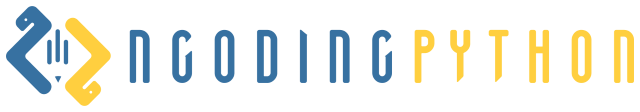

# Chatbot Sederhana dengan Scikit-Learn
Author : Afif A. Iskandar ([@afif.ai](https://instagram.com/afif.ai))

Notebook ini merupakan implementasi pembuatan chatbot AI  sederhana dengan menggunakan scikit-learn

In [105]:
# import library
import string
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from util import JSONParser

### Load Data

Data yang digunakan merupakan data JSON sesuai dengan struktur yang dijelaskan didalam video. Tujuannya adalah mengubah bentuk JSON menjadi dalam bentuk tabel agar mudah ditraining menggunakan *scikit-learn*.
Saya sudah membuat parser khusus untuk data dengan format tersebut didalam direktori `util/` yang bernama `JSONParser`

In [2]:
# load data
path = "data/intents.json"

# buat objek JSONParser dan parse data intents.json
jp = JSONParser()
jp.parse(path)

# simpan dataframe dalam variabel df
df = jp.get_dataframe()

[INFO] Data JSON converted to DataFrame with shape : (57, 2)


In [3]:
# lihat 5 data pertama
df.head()

,text_input,intents
0,Hai,salam
1,Hi,salam
2,Halo,salam
3,Apa Kabar,salam
4,Selamat Pagi,salam


In [4]:
# hitung jumlah data per tag / inten
df.intents.value_counts()

salam                 10
bye                    8
komunitas              7
nama                   6
ngodingpython_typo     6
pekerjaan              5
ngodingpython          5
youtube                5
kemampuan              5
Name: intents, dtype: int64

### Praproses Data

Pada bagian ini data training akan dibersihkan dan dilakukan praproses apabila diperlukan.

Praproses yang dilakukan adalah : 
- Case Folding : Mengubah semua alfabet menjadi huruf kecil
- Menghapus tanda baca

Jika dibutuhkan bisa diimplementasikan praproses lain seperti menghapus angka, menghapus spasi berlebih, stemming, lemmatization, POS TAGGING, NER, dsb.

Anda juga bisa mengubah metode praproses ini dengan lebih efisien, misal menggunakan Regular Expression atau *RegEx*

In [30]:
def preprocess(chat):
    """
    Fungsi yang digunakan untuk melakukan praproses
    """
    # konversi ke lowercase
    chat = chat.lower()
    # menghapus tanda baca
    tandabaca = tuple(string.punctuation)
    chat = ''.join(ch for ch in chat if ch not in tandabaca)
    return chat

In [32]:
# implementasikan fungsi preprocess ke string
df['text_input_prep'] = df.text_input.apply(preprocess)

Apabila kita lihat hasilnya maka kita dapati hal berikut : 

In [23]:
df[['text_input', 'text_input_prep']].head(10)

,text_input,text_input_prep
0,Hai,hai
1,Hi,hi
2,Halo,halo
3,Apa Kabar,apa kabar
4,Selamat Pagi,selamat pagi
5,Selamat Siang,selamat siang
6,Selamat Malam,selamat malam
7,Salam,salam
8,Ping,ping
9,P,p


Kita dapat lihat bahwa kolom kiri merupakan kolom data sebelum di praproses sedangkan yang kanan adalah input yang sudah di praproses

### Vektorisasi

Sebelum kita masukkan data kita kedalam algoritma machine learning, kita perlu melakukan vektorisasi terlebih dahulu. Karena input yang diterima oleh model machine learning harus berupa matriks sedangkan dataset yang kita proses berupa teks.

Metode vektorisasi paling sederhana adalah metode *bag of words* yaitu metode pengumpulan *vocab* yang terdapat pada *corpus*.
Metode *bag of words* yang paling sederhana adalah metode `CountVectorizer` yang terdapat pada *scikit-learn*.

Anda juga dapat menggunakan metode lain misalnya `TfidfVectorizer`, dengan mengimport dari `sklearn.feature_extraction.text` persis seperti metode `CountVectorizer`

In [33]:
# inisiasi objek CountVectorizer
vect = CountVectorizer()

Langkah penting dalam metode *bag of words* adalah mengumpulkan *vocab* yang terdapat pada *corpus* yang kita miliki. Dalam scikit-learn kita dapat lakukan dengan cara :

In [34]:
# mengumpulkan vocab dari data teks yang sudah dilakukan praproses
vect.fit(df['text_input_prep'])

CountVectorizer()

In [36]:
# lihat list vocab
vect.get_feature_names()[:10] #batasi hanya 10 vocab teratas

['ada',
 'aja',
 'anda',
 'apa',
 'apaan',
 'bantu',
 'bantuin',
 'bisa',
 'bye',
 'channel']

Selanjutnya konversi data teks menjadi matriks sesuai vocab yang sudah dibuat

In [39]:
# ubah data teks menjadi matriks
text_vect = vect.transform(df.text_input_prep)

text_vect

<57x81 sparse matrix of type '<class 'numpy.int64'>'
	with 160 stored elements in Compressed Sparse Row format>

Kita bisa lihat bahwa data teks kita sudah berubah menjadi bentuk *sparse matrix*
(Opsional) Jika anda orangnya sangat-sangat penasaran dengan hasil yang dibuat diatas, kita coba lihat hasil matriksnya dengan bantuan pandas

In [44]:
pd.DataFrame(text_vect.toarray(), columns=vect.get_feature_names())

d:\project\chatbot_tutorial\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ada,aja,anda,apa,apaan,bantu,bantuin,bisa,bye,channel,...,sih,tanyatanya,tinggal,tugas,tuh,urlnya,wah,ya,yang,youtube
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Jika anda bekerja dengan data yang besar, anda tidak disarankan melihat representasi matriks datanya karena akan membuat komputer kita menjadi berat

### Modelling

Setelah data siap, saatnya ditrain kedalam algoritma machine learning.
Dalam kasus ini kita menggunakan Multinomial Naive Bayes

In [45]:
# deklarasi objek MultinomialNB
nb = MultinomialNB()

# training data, dengan X : text_vect dan y : intents
nb.fit(text_vect, df.intents)

MultinomialNB()

Setelah model dilatih kita coba keluarkan hasil prediksi dari suatu input

In [50]:
# input string dari user
chat = input("Masukkan String : ")

# lakukan preproses
chat = preprocess(chat)

# ubah teks menjadi vektor
chat = vect.transform([chat])

# prediksi vektor teks kedalam model machine learning
res = nb.predict(chat)

# tampilkan hasil prediksi
print(f"Hasil prediksi : {res[0]}")

Masukkan String : apa sih ngodingpiton itu ?
Hasil prediksi : ngodingpython_typo


Supaya hasil menjadi lebih natural, kita lakukan prediksi dengan probabilitas sehingga apabila hasil prediksi kurang dari threshold probabilitas yang ditentukan, kita bisa buat bot untuk bilang "tidak mengerti"

In [61]:
# input string dari user
chat = input("Masukkan String : ")

# lakukan preproses
chat = preprocess(chat)

# ubah teks menjadi vektor
chat = vect.transform([chat])

# prediksi vektor teks kedalam model machine learning
res = nb.predict_proba(chat)

# ambil nilai probabilitas tertinggi
max_prob = max(res[0])
max_idx = np.argmax(res[0])
print(f"Max Prob : {max_prob}\nMax Index: {max_idx}\nLabel: {nb.classes_[max_idx]}")

Masukkan String : ngodingpiton apaan sih
Max Prob : 0.49028535724847366
Max Index: 5
Label: ngodingpython_typo


### Efisiensi dengan Pipeline

Dari proses diatas kita bisa lihat apabila ada data teks maka kita perlu proses dalam dua langkah, yaitu vektorisasi dan pemodelan. Supaya proses menjadi lebih ringkas dan lebih mudah dalam proses deployment, kita akan buat pipeline

In [63]:
# Deklarasi pipeline yang mengandung vektorisasi (CountVectorizer) & pemodelan (MultinomialNB) 
pipe = make_pipeline(CountVectorizer(),
                     MultinomialNB())

# Training
pipe.fit(df.text_input, df.intents)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

Dapat kita lihat dari proses training diatas, seolah-olah kita langsung memasukkan data teks dan labelnya langsung kedalam "*black box*" sehingga proses prediksi akan lebih ringkas.

Untuk inference dengan pipeline dapat kita lakukan dengan cara berikut : 

In [101]:
# input string dari user
chat = input("Masukkan String : ")

# lakukan preproses
chat = preprocess(chat)

# prediksi teks kedalam pipeline
res = pipe.predict_proba([chat])

# ambil nilai probabilitas tertinggi
max_prob = max(res[0])
max_idx = np.argmax(res[0])
print(f"Max Prob : {max_prob}\nMax Index: {max_idx}\nLabel: {nb.classes_[max_idx]}")

Masukkan String : halo
Max Prob : 0.3104999468431081
Max Index: 7
Label: salam


Dapat kita lihat bahwa teks baru setelah praproses bisa langsung masuk kedalam pipeline

### Simulasi Inference

Selanjutnya kita akan simulasikan chatbot mulai dari mendapatkan input sampai ke respon

Dalam kasus ini apabila intent yang terdeteksi adalah `bye` maka program berhenti

In [104]:
print("Anda Terhubung dengan chatbot Kami")
while True:
    # input user
    chat = input("Anda : ")
    # praproses
    chat = preprocess(chat)
    # prediksi intent
    res = pipe.predict_proba([chat])
    # ambil nilai probabilitas & lokasinya
    max_prob = max(res[0])
    max_idx = np.argmax(res[0])
    # kondisi jika probabilitas kurang dari threshold
    if max_prob < 0.20:
        print("Bot : Maaf Kak, aku ga ngerti")
    else:
        print(f"Bot : {jp.get_response(nb.classes_[max_idx])}")
    if nb.classes_[max_idx] == 'bye':
        break
    

Anda Terhubung dengan chatbot Kami
Anda : HAI
Bot : Halo!
Anda : nama lu siapa ?
Bot : Namaku Ngopy, salam kenal kak!
Anda : bisa apa aja lu ngopy?
Bot : Kakak bisa tanya-tanya nama aku, apa yang aku lakukan dan yang berhubungan dengan channel NgodingPython
Anda : apaan tuh NgodingPhyton?
Bot : NgodingPython kaak, jangan bikin emosi deh
Anda : iye2 maap, NgodingPython maksudnya
Bot : NgodingPython adalah sebuah channel youtube yang diciptakan oleh kak Afif untuk sharing mengenai Python, Pemrograman dan yang berkaitan dengan itu kak 
Anda : hoo. minta dong link youtubenya ?
Bot : Bisa dilihat di https://youtube.com/NgodingPython, jangan lupa subscribe ya kak!
Anda : mantaaap.. kalau mau tanya2 gitu ada komunitas atau grupnya gitu ga ?
Bot : Langsung aja join ke telegram komunitas NgodingPython kak disini https://t.me/NgodingPython
Anda : sipsip makasih
Bot : Sampai jumpa lagi yaa


Setelah kita berhasil simulasikan bot nya dalam notebook ini, kita simpan modelnya agar dapat dideploy dengan mudah

In [106]:
with open("chatbot_pipeline.pkl", "wb") as model_file:
    pickle.dump(pipe, model_file)